<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 2: Hidden Markov Model

**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

**Content creators:** Yicheng Fei with help from Jesse Livezey and Xaq Pitkow

**Content reviewers:** John Butler, Matt Krause, Meenakshi Khosla, Spiros Chavlis, Michael Waskom

**Production editors:** Ella Batty, Gagana B, Spiros Chavlis

---
# Tutorial objectives

*Estimated timing of tutorial: 1 hour, 5 minutes*

The world around us is often changing, but we only have noisy sensory measurements. Similarly, neural systems switch between discrete states (e.g. sleep/wake) which are observable only indirectly, through their impact on neural activity. **Hidden Markov Models** (HMM) let us reason about these unobserved (also called hidden or latent) states using a time series of measurements.

Here we'll learn how changing the HMM's transition probability and measurement noise impacts the data. We'll look at how uncertainty increases as we predict the future, and how to gain information from the measurements.

We will use a binary latent variable $s_t \in \{0,1\}$ that switches randomly between the two states, and a 1D Gaussian emission model $m_t|s_t \sim \mathcal{N}(\mu_{s_t},\sigma^2_{s_t})$ that provides evidence about the current state.

By the end of this tutorial, you should be able to:
- Describe how the hidden states in a Hidden Markov model evolve over time, both in words, mathematically, and in code
- Estimate hidden states from data using forward inference in a Hidden Markov model
- Describe how measurement noise and state transition probabilities affect uncertainty in predictions in the future and the ability to estimate hidden states.

<br>

**Summary of Exercises**
1. Generate data from an HMM.
2. Calculate how predictions propagate in a Markov Chain without evidence.
3. Combine new evidence and prediction from past evidence to estimate hidden states.

In [1]:
# Imports
import numpy as np
import time
from scipy import stats
from scipy.optimize import linear_sum_assignment
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import patches

##  Figure Settings


In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

##  Plotting Functions


In [3]:
# @title Plotting Functions

def plot_hmm1(model, states, measurements, flag_m=True):
  """Plots HMM states and measurements for 1d states and measurements.

  Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    measurements (numpy array of floats): Samples of the states.
  """
  T = states.shape[0]
  nsteps = states.size
  aspect_ratio = 2
  fig, ax1 = plt.subplots(figsize=(8,4))
  states_forplot = list(map(lambda s: model.means[s], states))
  ax1.step(np.arange(nstep), states_forplot, "-", where="mid", alpha=1.0, c="green")
  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([-1, 1])
  ax1.set_yticklabels(["-1", "+1"])
  ax1.set_xticks(np.arange(0,T,10))
  ymin = min(measurements)
  ymax = max(measurements)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Measurements", c="crimson")

  # show measurement gaussian
  if flag_m:
    ax2.plot([T,T],ax2.get_ylim(), color="maroon", alpha=0.6)
    for i in range(model.n_components):
      mu = model.means[i]
      scale = np.sqrt(model.vars[i])
      rv = stats.norm(mu, scale)
      num_points = 50
      domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

      left = np.repeat(float(T), num_points)
      # left = np.repeat(0.0, num_points)
      offset = rv.pdf(domain)
      offset *= T / 15
      lbl = "measurement" if i == 0 else ""
      # ax2.fill_betweenx(domain, left, left-offset, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.scatter(np.arange(nstep), measurements, c="crimson", s=4)
      ax2.legend(loc="upper left")
    ax1.set_ylim(ax2.get_ylim())
  plt.show(fig)


def plot_marginal_seq(predictive_probs, switch_prob):
  """Plots the sequence of marginal predictive distributions.

    Args:
      predictive_probs (list of numpy vectors): sequence of predictive probability vectors
      switch_prob (float):                      Probability of switching states.
  """
  T = len(predictive_probs)
  prob_neg = [p_vec[0] for p_vec in predictive_probs]
  prob_pos = [p_vec[1] for p_vec in predictive_probs]
  fig, ax = plt.subplots()
  ax.plot(np.arange(T), prob_neg, color="blue")
  ax.plot(np.arange(T), prob_pos, color="orange")
  ax.legend([
    "prob in state -1", "prob in state 1"
  ])
  ax.text(T/2, 0.05, "switching probability={}".format(switch_prob), fontsize=12,
          bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6))
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability")
  ax.set_title("Forgetting curve in a changing world")
  plt.show(fig)


def plot_evidence_vs_noevidence(posterior_matrix, predictive_probs):
  """Plots the average posterior probabilities with evidence v.s. no evidence

  Args:
    posterior_matrix: (2d numpy array of floats): The posterior probabilities in state 1 from evidence (samples, time)
    predictive_probs (numpy array of floats):  Predictive probabilities in state 1 without evidence
  """
  nsample, T = posterior_matrix.shape
  posterior_mean = posterior_matrix.mean(axis=0)
  fig, ax = plt.subplots(1)
  ax.plot([0.0, T], [0., 0.], color="red", linestyle="dashed")
  ax.plot(np.arange(T), predictive_probs, c="orange", linewidth=2, label="No evidence")
  ax.scatter(np.tile(np.arange(T), (nsample, 1)), posterior_matrix, s=0.8,
             c="green", alpha=0.3, label="With evidence(Sample)")
  ax.plot(np.arange(T), posterior_mean, c='green',
          linewidth=2, label="With evidence(Average)")
  ax.legend()
  ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability in State +1")
  ax.set_title("Gain confidence with evidence")
  plt.show(fig)


def plot_forward_inference(model, states, measurements, states_inferred,
                           predictive_probs, likelihoods, posterior_probs,
                           t=None, flag_m=True, flag_d=True, flag_pre=True,
                           flag_like=True, flag_post=True):
  """Plot ground truth state sequence with noisy measurements, and ground truth states v.s. inferred ones

      Args:
          model (instance of hmmlearn.GaussianHMM): an instance of HMM
          states (numpy vector): vector of 0 or 1(int or Bool), the sequences of true latent states
          measurements (numpy vector of numpy vector): the un-flattened Gaussian measurements at each time point, element has size (1,)
          states_inferred (numpy vector): vector of 0 or 1(int or Bool), the sequences of inferred latent states
  """
  T = states.shape[0]
  if t is None:
    t = T-1
  nsteps = states.size
  fig, ax1 = plt.subplots(figsize=(11,6))
  # true states
  states_forplot = list(map(lambda s: model.means[s], states))
  ax1.step(np.arange(nstep)[:t+1], states_forplot[:t+1], "-", where="mid", alpha=1.0, c="green", label="true")
  ax1.step(np.arange(nstep)[t+1:], states_forplot[t+1:], "-", where="mid", alpha=0.3, c="green", label="")
  # Posterior curve
  delta = model.means[1] - model.means[0]
  states_interpolation = model.means[0] + delta * posterior_probs[:,1]
  if flag_post:
    ax1.step(np.arange(nstep)[:t+1], states_interpolation[:t+1], "-", where="mid", c="grey", label="posterior")

  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([-1, 1])
  ax1.set_yticklabels(["-1", "+1"])
  ax1.legend(bbox_to_anchor=(0,1.02,0.2,0.1), borderaxespad=0, ncol=2)

  ax2 = ax1.twinx()
  ax2.set_ylim(
      min(-1.2, np.min(measurements)),
      max(1.2, np.max(measurements))
      )
  if flag_d:
    ax2.scatter(np.arange(nstep)[:t+1], measurements[:t+1], c="crimson", s=4, label="measurement")
    ax2.set_ylabel("Measurements", c="crimson")

  # show measurement distributions
  if flag_m:
    for i in range(model.n_components):
      mu = model.means[i]
      scale = np.sqrt(model.vars[i])
      rv = stats.norm(mu, scale)
      num_points = 50
      domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

      left = np.repeat(float(T), num_points)
      offset = rv.pdf(domain)
      offset *= T /15
      lbl = ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
  ymin, ymax = ax2.get_ylim()
  width = 0.1 * (ymax-ymin) / 2.0
  centers = [-1.0, 1.0]
  bar_scale = 15

  # Predictions
  data = predictive_probs
  if flag_pre:
    for i in range(model.n_components):
      domain = np.array([centers[i]-1.5*width, centers[i]-0.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "todays prior" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="dodgerblue", label=lbl)

  # Likelihoods
  data = likelihoods
  data /= np.sum(data,axis=-1, keepdims=True)
  if flag_like:
    for i in range(model.n_components):
      domain = np.array([centers[i]+0.5*width, centers[i]+1.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "likelihood" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="crimson", label=lbl)
  # Posteriors
  data = posterior_probs
  if flag_post:
    for i in range(model.n_components):
      domain = np.array([centers[i]-0.5*width, centers[i]+0.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "posterior" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="grey", label=lbl)
  if t<T-1:
    ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)
  if flag_pre or flag_like or flag_post:
    ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)

    ax2.legend(bbox_to_anchor=(0.4,1.02,0.6, 0.1), borderaxespad=0, ncol=4)
  ax1.set_ylim(ax2.get_ylim())
  return fig
  # plt.show(fig)

---
# Section 1: Binary HMM with Gaussian measurements

In contrast to last tutorial, the latent state in an HMM is not fixed, but may switch to a different state at each time step. The time dependence is simple: the probability of the state at time $t$ is wholly determined by the state at time $t-1$. This is called called the **Markov property** and the dependency of the whole state sequence $\{s_1,...,s_t\}$ can be described by a chain structure called a Markov Chain. You have seen a Markov chain in the [pre-reqs Statistics day](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial2.html#section-1-2-markov-chains) and in the [Linear Systems Tutorial 2](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial2.html).


**Markov model for binary latent dynamics**

Let's reuse the binary switching process you saw in the [Linear Systems Tutorial 2](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial2.html): our state can be either +1 or -1. The probability of switching to state $s_t=j$ from the previous state $s_{t-1}=i$ is the conditional probability distribution $p(s_t = j| s_{t-1} = i)$. We can summarize these as a $2\times 2$ matrix we will denote $D$ for Dynamics.

\begin{align}
D = \begin{bmatrix}p(s_t = +1 | s_{t-1} = +1) & p(s_t = -1 | s_{t-1} = +1)\\p(s_t = +1 | s_{t-1} = -1)& p(s_t = -1 | s_{t-1} = -1)\end{bmatrix}
\end{align}

$D_{ij}$ represents the transition probability to switch from state $i$ to state $j$ at next time step. Please note that this is in contrast to the meaning used in the intro and in Linear Systems (their transition matrices are the transpose of ours) but syncs with the [pre-reqs Statistics day](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial2.html#section-1-2-markov-chains).

We can represent the probability of the _current_ state as a 2-dimensional vector

\begin{equation}
P_t = [p(s_t = +1), p(s_t = -1)]
\end{equation}

The entries are the probability that the current state is +1 and the probability that the current state is -1 so these must sum up to 1.

We then update the probabilities over time following the Markov process:

\begin{equation}
P_{t}= P_{t-1}D \tag{1}
\end{equation}

If you know the state, the entries of $P_{t-1}$ would be either 1 or 0 as there is no uncertainty.

**Measurements**

In a _Hidden Markov Model_, we cannot directly observe the latent states $s_t$. Instead we get noisy measurements $m_t\sim p(m|s_t)$.

## Coding Exercise 1.1: Simulate a binary HMM with Gaussian measurements

In this exercise, you will implement a binary HMM with Gaussian measurements. Your HMM will start in State +1 and transition between states (both $-1 \rightarrow 1$ and $1 \rightarrow -1$) with probability `switch_prob`. Each state emits measurements drawn from a Gaussian with mean $+1$ for State +1 and mean $-1$ for State -1. The standard deviation of both states is given by `noise_level`.

The exercises in the next cell have three steps:

**STEP 1**. In `create_HMM`, complete the transition matrix  `transmat_` (i.e., $D$) in the code.

\begin{equation}
D =
\begin{pmatrix}
p_{\rm stay} & p_{\rm switch} \\
p_{\rm switch} & p_{\rm stay} \\
\end{pmatrix}
\end{equation}

with $p_{\rm stay} = 1 - p_{\rm switch}$.

**STEP 2**. In `create_HMM`, specify gaussian measurements $m_t | s_t$, by specifying the means for each state, and the standard deviation.

**STEP 3**. In `sample`, use the transition matrix to specify the probabilities for the next state $s_t$ given the previous state $s_{t-1}$.


In this exercise, we will use a helper data structure named `GaussianHMM1D`, implemented in the following cell. This allows us to set the information we need about the HMM model (the starting probabilities of state, the transition matrix, the means and variances of the Gaussian distributions, and the number of components) and easily access it. For example, if we can set our model using:


```python
  model = GaussianHMM1D(
    startprob = startprob_vec,
    transmat = transmat_mat,
    means = means_vec,
    vars = vars_vec,
    n_components = n_components
  )
```
and then access the variances as:

```python
model.vars
```

Also note that we refer to the states as `0` and `1` in the code, instead of as `-1` and `+1`.

In [4]:
GaussianHMM1D = namedtuple('GaussianHMM1D', ['startprob', 'transmat','means','vars','n_components'])

In [5]:
def create_HMM(switch_prob=0.1, noise_level=1e-1, startprob=[1.0, 0.0]):
  """Create an HMM with binary state variable and 1D Gaussian measurements
  The probability to switch to the other state is `switch_prob`. Two
  measurement models have mean 1.0 and -1.0 respectively. `noise_level`
  specifies the standard deviation of the measurement models.

  Args:
      switch_prob (float): probability to jump to the other state
      noise_level (float): standard deviation of measurement models. Same for
      two components

  Returns:
      model (GaussianHMM instance): the described HMM
  """

  ############################################################################
  # Insert your code here to:
  #   * Create the transition matrix, `transmat_mat` so that the odds of
  #      switching is `switch_prob`
  #		* Set the measurement model variances, to `noise_level ^ 2` for both
  #      states
  # raise NotImplementedError("`create_HMM` is incomplete")
  ############################################################################

  n_components = 2

  startprob_vec = np.asarray(startprob)

  # STEP 1: Transition probabilities
  transmat_mat = np.array([[1-switch_prob, switch_prob], [switch_prob, 1-switch_prob]]) # np.array([[...], [...]])

  # STEP 2: Measurement probabilities

  # Mean measurements for each state
  means_vec = np.array([-1, 1])

  # Noise for each state
  vars_vec = np.ones(2) * noise_level**2

  # Initialize model
  model = GaussianHMM1D(
    startprob = startprob_vec,
    transmat = transmat_mat,
    means = means_vec,
    vars = vars_vec,
    n_components = n_components
  )

  return model


def sample(model, T):
  """Generate samples from the given HMM

  Args:
    model (GaussianHMM1D): the HMM with Gaussian measurement
    T (int): number of time steps to sample

  Returns:
    M (numpy vector): the series of measurements
    S (numpy vector): the series of latent states

  """
  ############################################################################
  # Insert your code here to:
  #   * take row i from `model.transmat` to get the transition probabilities
  #       from state i to all states
  # raise NotImplementedError("`sample` is incomplete")
  ############################################################################
  # Initialize S and M
  S = np.zeros((T,),dtype=int)
  M = np.zeros((T,))

  # Calculate initial state
  S[0] = np.random.choice([0,1],p=model.startprob)

  # Latent state at time `t` depends on `t-1` and the corresponding transition probabilities to other states
  for t in range(1,T):

    # STEP 3: Get vector of probabilities for all possible `S[t]` given a particular `S[t-1]`
    transition_vector = model.transmat[S[t-1]]

    # Calculate latent state at time `t`
    S[t] = np.random.choice([0,1],p=transition_vector)

  # Calculate measurements conditioned on the latent states
  # Since measurements are independent of each other given the latent states, we could calculate them as a batch
  means = model.means[S]
  scales = np.sqrt(model.vars[S])
  M = np.random.normal(loc=means, scale=scales, size=(T,))

  return M, S


# Set random seed
np.random.seed(101)

# Set parameters of HMM
T = 100
switch_prob = 0.1
noise_level = 2.0

# Create HMM
model = create_HMM(switch_prob=switch_prob, noise_level=noise_level)

# Sample from HMM
M, S = sample(model,T)
assert M.shape==(T,)
assert S.shape==(T,)

# Print values
print(M[:5])
print(S[:5])

[-3.09355908  1.58552915 -3.93502804 -1.98819072 -1.32506947]
[0 0 0 0 0]


You should see that the first five measurements are:

 `[-3.09355908  1.58552915 -3.93502804 -1.98819072 -1.32506947]`

 while the first five states are:

 `[0 0 0 0 0]`

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial2_Solution_9035e19a.py)



## Interactive Demo 1.2: Binary HMM

In the demo below, we simulate and plot a similar HMM. You can change the probability of switching states and the noise level (the standard deviation of the Gaussian distributions for measurements). You can click the empty box to also visualize the measurements.

**First**, think about and discuss these questions:

1.   What will the states do if the switching probability is zero? One?
2.   What will measurements look like with high noise? Low?



**Then**, play with the demo to see if you were correct or not.

 Execute this cell to enable the widget!


In [6]:
# @markdown Execute this cell to enable the widget!

nstep = 100

@widgets.interact
def plot_samples_widget(
    switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.02, value=0.1),
    log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=-0.3),
    flag_m=widgets.Checkbox(value=False, description='measurements',
                            disabled=False, indent=False)
    ):
  np.random.seed(101)
  model = create_HMM(switch_prob=switch_prob,
                     noise_level=10.**log10_noise_level)
  print(model)
  observations, states = sample(model, nstep)
  plot_hmm1(model, states, observations, flag_m=flag_m)

interactive(children=(FloatSlider(value=0.1, description='switch_prob', max=1.0, step=0.02), FloatSlider(value…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial2_Solution_f836b25b.py)




**Applications**. Measurements could be:
* fish caught at different times as the school of fish moves from left to right
* membrane voltage when an ion channel changes between open and closed
* EEG frequency measurements as the brain moves between sleep states

What phenomena can you imagine modeling with these HMMs?

----

# Section 2: Predicting the future in an HMM


*Estimated timing to here from start of tutorial: 20 min*





### Interactive Demo 2.1: Forgetting in a changing world


Even if we know the world state for sure, the world changes. We become less and less certain as time goes by since our last measurement. In this exercise, we'll see how a Hidden Markov Model gradually "forgets" the current state when predicting the future without measurements.

Assume we know that the initial state is -1, $s_0=-1$, so $p(s_0)=[1,0]$. We will plot $p(s_t)$ versus time.

1. Examine helper function `simulate_prediction_only` and understand how the predicted distribution changes over time.

2. Using our provided code, plot this distribution over time, and manipulate the process dynamics via the slider controlling the switching probability.

Do you forget more quickly with low or high switching probability? Why? How does the curve look when `prob_switch` $>0.5$? Why?





 Execute this cell to enable helper function `simulate_prediction_only`


In [7]:
# @markdown Execute this cell to enable helper function `simulate_prediction_only`

def simulate_prediction_only(model, nstep):
  """
  Simulate the diffusion of HMM with no observations

  Args:
    model (GaussianHMM1D instance): the HMM instance
    nstep (int): total number of time steps to simulate(include initial time)

  Returns:
    predictive_probs (list of numpy vector): the list of marginal probabilities
  """
  entropy_list = []
  predictive_probs = []
  prob = model.startprob
  for i in range(nstep):

    # Log probabilities
    predictive_probs.append(prob)

    # One step forward
    prob = prob @ model.transmat

  return predictive_probs

 Execute this cell to enable the widget!


In [8]:
# @markdown Execute this cell to enable the widget!

np.random.seed(101)
T = 100
noise_level = 0.5

@widgets.interact(switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.01,
                                                  value=0.1))
def plot(switch_prob=switch_prob):
  model = create_HMM(switch_prob=switch_prob, noise_level=noise_level)
  predictive_probs = simulate_prediction_only(model, T)
  plot_marginal_seq(predictive_probs, switch_prob)

interactive(children=(FloatSlider(value=0.1, description='switch_prob', max=1.0, step=0.01), Output()), _dom_c…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial2_Solution_6ab76076.py)



# Section 3: Forward inference in an HMM

*Estimated timing to here from start of tutorial: 35 min*

### Coding Exercise 3.1: Forward inference of HMM

As a recursive algorithm, let's assume we already have yesterday's posterior from time $t-1$: $p(s_{t-1}|m_{1:t-1})$. When the new data $m_{t}$ comes in, the algorithm performs the following steps:

* **Predict**: transform yesterday's posterior over $s_{t-1}$ into today's prior over $s_t$ using the transition matrix $D$:

\begin{equation}
\text{today's prior}=p(s_t|m_{1:t-1})= p(s_{t-1}|m_{1:t-1}) D
\end{equation}

* **Update**: Incorporate measurement $m_t$ to calculate the posterior $p(s_t|m_{0:t})$

\begin{equation}
\text{posterior} \propto \text{prior}\cdot \text{likelihood}=p(m_t|s_t)p(s_t|m_{0:t-1})
\end{equation}

In this exercise, you will:

* STEP 1: Complete the code in function `markov_forward` to calculate the predictive marginal distribution at next time step

* STEP 2: Complete the code in function `one_step_update` to combine predictive probabilities and data likelihood into a new posterior
  * Hint: We have provided a function to calculate the likelihood of $m_t$ under the two possible states: `compute_likelihood(model,M_t)`.

* STEP 3: Using code we provide, plot the posterior and compare with the true values

The complete forward inference is implemented in `simulate_forward_inference` which just calls `one_step_update` recursively.

 Execute to enable helper functions `compute_likelihood` and `simulate_forward_inference`


In [9]:
# @markdown Execute to enable helper functions `compute_likelihood` and `simulate_forward_inference`

def compute_likelihood(model, M):
  """
  Calculate likelihood of seeing data `M` for all measurement models

  Args:
    model (GaussianHMM1D): HMM
    M (float or numpy vector)

  Returns:
    L (numpy vector or matrix): the likelihood
  """
  rv0 = stats.norm(model.means[0], np.sqrt(model.vars[0]))
  rv1 = stats.norm(model.means[1], np.sqrt(model.vars[1]))
  L = np.stack([rv0.pdf(M), rv1.pdf(M)],axis=0)
  if L.size==2:
    L = L.flatten()
  return L


def simulate_forward_inference(model, T, data=None):
  """
  Given HMM `model`, calculate posterior marginal predictions of x_t for T-1 time steps ahead based on
  evidence `data`. If `data` is not give, generate a sequence of measurements from first component.

  Args:
    model (GaussianHMM instance): the HMM
    T (int): length of returned array

  Returns:
    predictive_state1: predictive probabilities in first state w.r.t no evidence
    posterior_state1: posterior probabilities in first state w.r.t evidence
  """

  # First re-calculate hte predictive probabilities without evidence
  # predictive_probs = simulate_prediction_only(model, T)
  predictive_probs = np.zeros((T,2))
  likelihoods = np.zeros((T,2))
  posterior_probs = np.zeros((T, 2))
  # Generate an measurement trajectory condtioned on that latent state x is always 1
  if data is not None:
    M = data
  else:
    M = np.random.normal(model.means[0], np.sqrt(model.vars[0]), (T,))

  # Calculate marginal for each latent state x_t
  predictive_probs[0,:] = model.startprob
  likelihoods[0,:] = compute_likelihood(model, M[[0]])
  posterior = predictive_probs[0,:] * likelihoods[0,:]
  posterior /= np.sum(posterior)
  posterior_probs[0,:] = posterior

  for t in range(1, T):
    prediction, likelihood, posterior = one_step_update(model, posterior_probs[t-1], M[[t]])
    # normalize and add to the list
    posterior /= np.sum(posterior)
    predictive_probs[t,:] = prediction
    likelihoods[t,:] = likelihood
    posterior_probs[t,:] = posterior
  return predictive_probs, likelihoods, posterior_probs

help(compute_likelihood)
help(simulate_forward_inference)

Help on function compute_likelihood in module __main__:

compute_likelihood(model, M)
    Calculate likelihood of seeing data `M` for all measurement models
    
    Args:
      model (GaussianHMM1D): HMM
      M (float or numpy vector)
    
    Returns:
      L (numpy vector or matrix): the likelihood

Help on function simulate_forward_inference in module __main__:

simulate_forward_inference(model, T, data=None)
    Given HMM `model`, calculate posterior marginal predictions of x_t for T-1 time steps ahead based on
    evidence `data`. If `data` is not give, generate a sequence of measurements from first component.
    
    Args:
      model (GaussianHMM instance): the HMM
      T (int): length of returned array
    
    Returns:
      predictive_state1: predictive probabilities in first state w.r.t no evidence
      posterior_state1: posterior probabilities in first state w.r.t evidence



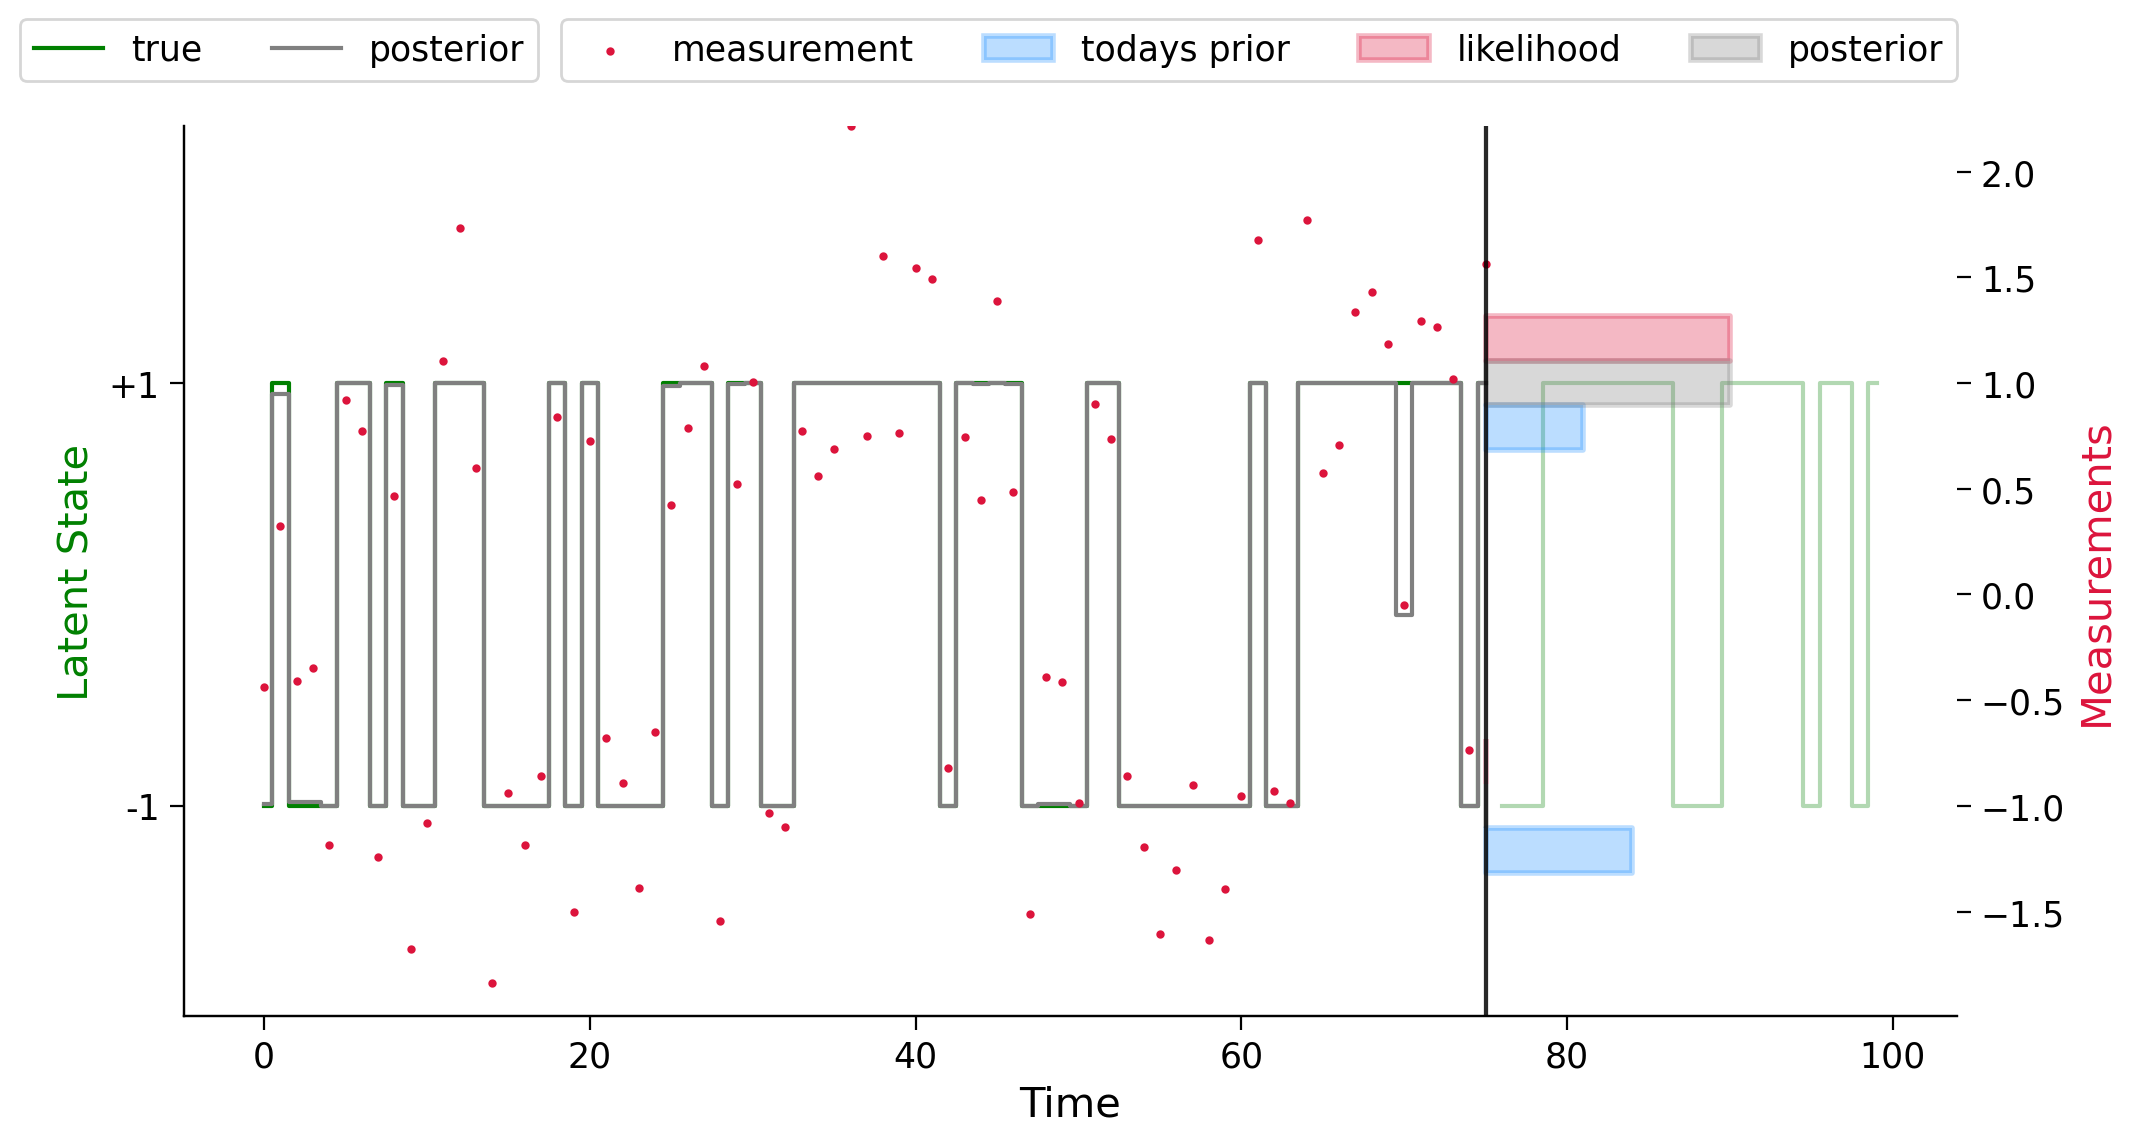

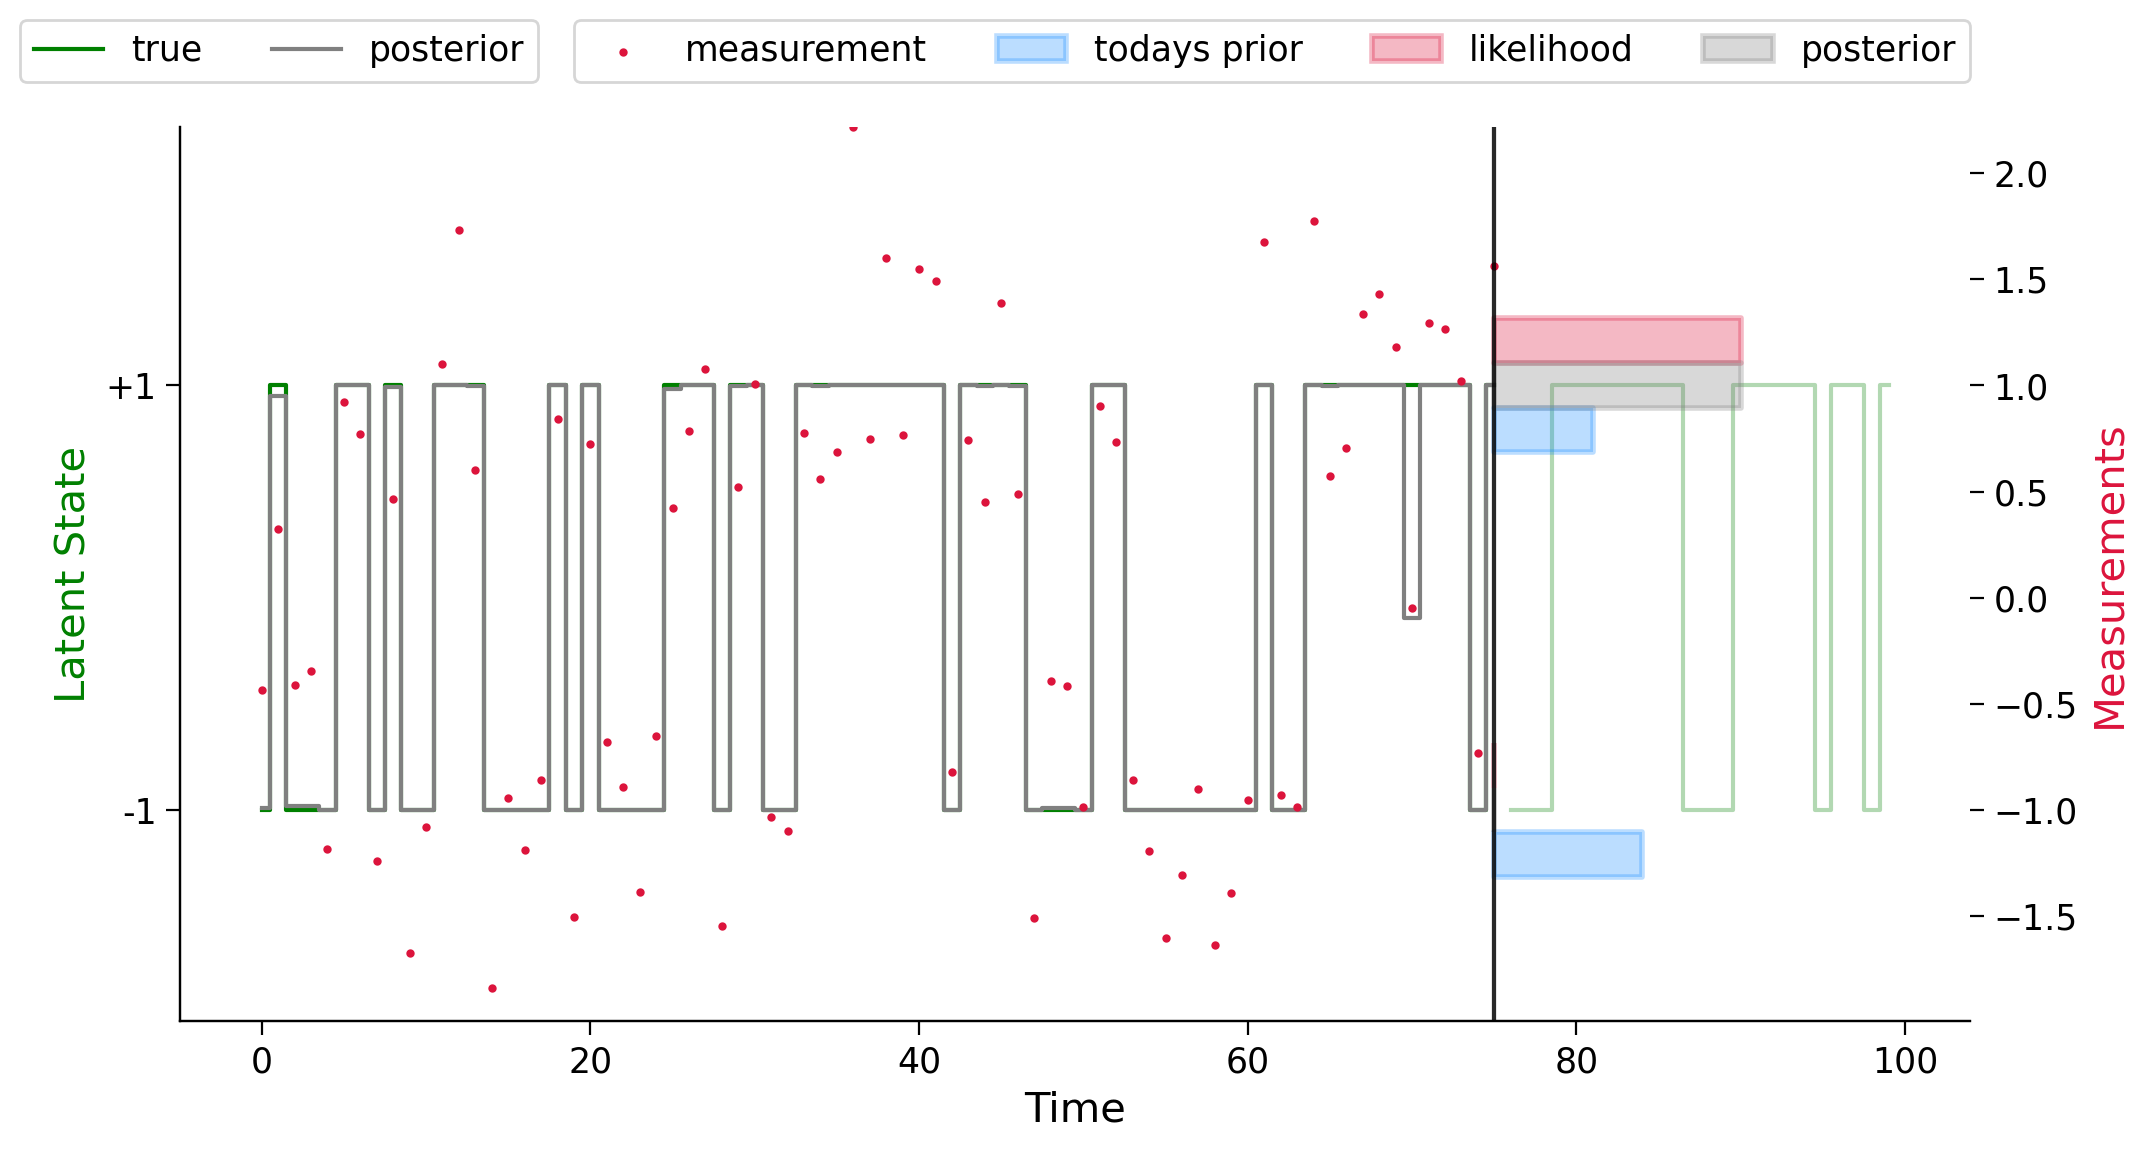

In [10]:
def markov_forward(p0, D):
  """Calculate the forward predictive distribution in a discrete Markov chain

  Args:
    p0 (numpy vector): a discrete probability vector
    D (numpy matrix): the transition matrix, D[i,j] means the prob. to
    switch FROM i TO j

  Returns:
    p1 (numpy vector): the predictive probabilities in next time step
  """
  ##############################################################################
  # Insert your code here to:
  #    1. Calculate the predicted probabilities at next time step using the
  #      probabilities at current time and the transition matrix
  # raise NotImplementedError("`markov_forward` is incomplete")
  ##############################################################################

  # Calculate predictive probabilities (prior)
  p1 = D @ p0

  return p1

def one_step_update(model, posterior_tm1, M_t):
  """Given a HMM model, calculate the one-time-step updates to the posterior.
  Args:
    model (GaussianHMM1D instance): the HMM
    posterior_tm1 (numpy vector): Posterior at `t-1`
    M_t (numpy array): measurement at `t`

  Returns:
    posterior_t (numpy array): Posterior at `t`
  """
  ##############################################################################
  # Insert your code here to:
  #    1. Call function `markov_forward` to calculate the prior for next time
  #      step
  #    2. Calculate likelihood of seeing current data `M_t` under both states
  #      as a vector.
  #    3. Calculate the posterior which is proportional to
  #      likelihood x prediction elementwise,
  #    4. Don't forget to normalize
  # raise NotImplementedError("`one_step_update` is incomplete")
  ##############################################################################

  # Calculate predictive probabilities (prior)
  prediction = markov_forward(posterior_tm1, model.transmat)

  # Get the likelihood
  likelihood = compute_likelihood(model, M_t)

  # Calculate posterior
  posterior_t = likelihood * prediction

  # Normalize
  posterior_t /= np.sum(posterior_t)

  return prediction, likelihood, posterior_t


# Set random seed
np.random.seed(12)

# Set parameters
switch_prob = 0.4
noise_level = .4
t = 75

# Create and sample from model
model = create_HMM(switch_prob = switch_prob,
                    noise_level = noise_level,
                    startprob=[0.5, 0.5])

measurements, states = sample(model, nstep)

# Infer state sequence
predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(model, nstep,
                                                            measurements)
states_inferred = np.asarray(posterior_probs[:,0] <= 0.5, dtype=int)

# Visualize
plot_forward_inference(
      model, states, measurements, states_inferred,
      predictive_probs, likelihoods, posterior_probs,t=t, flag_m = 0
    )

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial2_Solution_69ce2879.py)

*Example output:*

<img alt='Solution hint' align='left' width=1072.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial2_Solution_69ce2879_1.png>



## Interactive Demo 3.2: Forward inference in binary HMM

Now visualize your inference algorithm. Play with the sliders and checkboxes to help you gain intuition.

* Use the sliders `switch_prob` and `log10_noise_level` to change the switching probability and measurement noise level.

* Use the slider `t` to view prediction (prior) probabilities, likelihood, and posteriors at different times.

When does the inference make a mistake? For example, set `switch_prob=0.1`, `log_10_noise_level=-0.2`, and take a look at the probabilities at time `t=2`.

 Execute this cell to enable the widget


In [11]:
# @markdown Execute this cell to enable the widget

nstep = 100

@widgets.interact
def plot_forward_inference_widget(
    switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05),
    log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=0.1),
    t=widgets.IntSlider(min=0, max=nstep-1, step=1, value=nstep//2),
    flag_d=widgets.Checkbox(value=True, description='measurements',
                            disabled=False, indent=False),
    flag_pre=widgets.Checkbox(value=True, description='todays prior',
                              disabled=False, indent=False),
    flag_like=widgets.Checkbox(value=True, description='likelihood',
                               disabled=False, indent=False),
    flag_post=widgets.Checkbox(value=True, description='posterior',
                               disabled=False, indent=False),
    ):

  np.random.seed(102)

  # global model, measurements, states, states_inferred, predictive_probs, likelihoods, posterior_probs
  model = create_HMM(switch_prob=switch_prob,
                      noise_level=10.**log10_noise_level,
                      startprob=[0.5, 0.5])
  measurements, states = sample(model, nstep)

  # Infer state sequence
  predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(model, nstep,
                                                              measurements)
  states_inferred = np.asarray(posterior_probs[:,0] <= 0.5, dtype=int)

  fig = plot_forward_inference(
        model, states, measurements, states_inferred,
        predictive_probs, likelihoods, posterior_probs,t=t,
        flag_m=0,
        flag_d=flag_d,flag_pre=flag_pre,flag_like=flag_like,flag_post=flag_post
      )
  plt.show(fig)

interactive(children=(FloatSlider(value=0.05, description='switch_prob', max=1.0, step=0.01), FloatSlider(valu…

---
# Summary

*Estimated timing of tutorial: 1 hour, 5 minutes*

In this tutorial, you

* Simulated the dynamics of the hidden state in a Hidden Markov model and visualized the measured data (Section 1)
* Explored how uncertainty in a future hidden state changes based on the probabilities of switching between states (Section 2)
* Estimated hidden states from the measurements using forward inference, connected this to Bayesian ideas, and explored the effects of noise and transition matrix probabilities on this process (Section 3)